In [1]:
import sys
import numpy as np
import open3d as o3d
import cv2 as cv
import glob
import importlib
import pathlib
from scipy.spatial.transform import Rotation as R
import os

sys.path.append("../../")
from data_processor import IntrinsicCalib, mp4ToPng
from CT_data_registration import o3d_ICP

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
importlib.reload(IntrinsicCalib)
importlib.reload(mp4ToPng)

<module 'data_processor.mp4ToPng' from '/home/fj/Projects/ARPA-H/Scripts/20241113_Optical_Track_TRE/../../data_processor/mp4ToPng.py'>

1. Manually identify timestamps during which the markers are touched.
2. Extrac tool and phantom coordinates during these time frames
3. Registration
4. Error Computation

Markers from right to left: 1, 2, 3, 4, 5

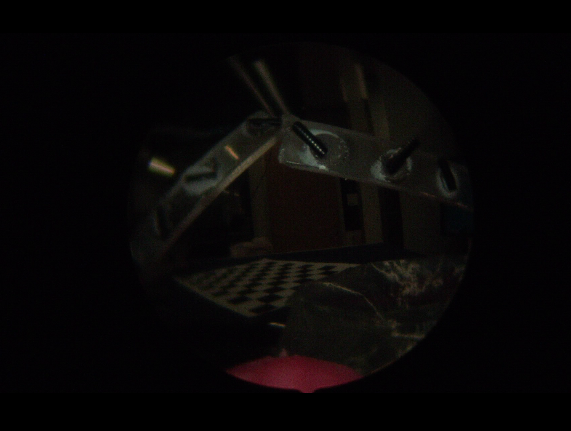

2. [1729869824290, 1729869824859]
3. [1729869808942, 1729869809512]
4. [1729869804605, 1729869804506]
5. [1729869816118, 1729869816450]



In [3]:
# Define the dimensions of the checkerboard (number of inner corners per row and column)
CHECKERBOARD_SHAPE = (10, 7)  # Adjust according to your checkerboard dimensions
CHECKERBOARD_GRID_SIZE = 20 # mm

videoBasePath = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241011_phantom_mono/Recordings/run_4")
videoPath = videoBasePath / "Oct11_BPH_Recording5.avi"
imageBasePath = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241011_phantom_mono/Recordings/run_5/checkerboard/cam0")
imagePath = imageBasePath / "data"
timeStampsPath = videoBasePath / "Oct11_BPH_Recording5.csv"
timeStamps = np.genfromtxt(timeStampsPath, delimiter=",", dtype=np.double)[:, 1]


bphVideoBasePath = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241011_phantom_mono/Recordings/run_5")
bphVideoPath = bphVideoBasePath / "Oct11_BPH_Recording6.avi"
bphImageBasePath = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241011_phantom_mono/Recordings/run_5/BPH/cam0")
bphImagePath = bphImageBasePath / "data"
bphTimeStampsPath = bphVideoBasePath / "Oct11_BPH_Recording6.csv"
bphTimeStamps = np.genfromtxt(bphTimeStampsPath, delimiter=",", dtype=np.double)[:, 1]

VSLAM_RECON_PATH = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241011_phantom_mono/Recordings/run_5/BPH/slam_reconstruction")


In [3]:
# Define the dimensions of the checkerboard (number of inner corners per row and column)
# CHECKERBOARD = (10, 7)  # Adjust according to your checkerboard dimensions
CHECKERBOARD_SHAPE = (9, 6)  # Adjust according to your checkerboard dimensions
CHECKERBOARD_GRID_SIZE = 20 # mm

videoBasePath = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241025_phantom_mono_tre/White/run_cb")
videoPath = videoBasePath / "Oct25_BPH_White_cb.avi"
imageBasePath = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241025_phantom_mono_tre/White/run_cb/checkerboard/cam0")
imagePath = imageBasePath / "data"
timeStampsPath = videoBasePath / "Oct25_BPH_White_cb.csv"
timeStamps = np.genfromtxt(timeStampsPath, delimiter=",", dtype=np.double)[:, 1]

bphVideoBasePath = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241025_phantom_mono_tre/White/run_2")
bphVideoPath = bphVideoBasePath / "Oct25_BPH_White_2.avi"
bphImageBasePath = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241025_phantom_mono_tre/White/run_2/BPH/cam0")
bphImagePath = bphImageBasePath / "data"
bphTimeStampsPath = bphVideoBasePath / "Oct25_BPH_White_2.csv"
bphTimeStamps = np.genfromtxt(bphTimeStampsPath, delimiter=",", dtype=np.double)[:, 1]

VSLAM_RECON_PATH = pathlib.Path("/media/fj/Data/Projects/ARPA-H/data/20241025_phantom_mono_tre/White/run_2/BPH/slam_reconstruction")


In [4]:
mp4ToPng.saveFramesAsPng(bphVideoPath, bphImagePath, newSize=(640, 360), timeStamps=bphTimeStamps)


2905, 1729869836402

## Obtain NID track data corressponding to VSLAM Reconstruction

In [27]:


PtTimeRange2 = [1729869824290, 1729869824859]
PtTimeRange3 = [1729869808942, 1729869809512] # 1729869819052, 1729869819585
PtTimeRange4 = [1729869804370, 1729869804738]
PtTimeRange5 = [1729869815517, 1729869816450]

# PtTimeRange0 = [1728660361322, 1728660363157]
# PtTimeRange2 = [1728660353650, 1728660357284]
# PtTimeRange3 = [1728660345473, 1728660345840]
# PtTimeRange4 = [1728660370999, 1728660375770]
# PtTimeRange5 = [1728660377404, 1728660383945]
# PtTimeRange6 = [1728660385747, 1728660386950]

PTTimeRanges = np.array([PtTimeRange2, PtTimeRange3, PtTimeRange4])

In [28]:
def compute_transformation_from_B_to_A(data):
    n = data.shape[0]
    transformations = []

    for i in range(n):
        # Extract translations and quaternions for A and B
        if np.any(np.isnan(data[i, :])):
            continue
        a_translation = data[i, 1:4]
        a_quaternion = data[i, 4:8]  # Assuming (x, y, z, w) order
        b_translation = data[i, 8:11]
        b_quaternion = data[i, 11:15]
        
        # Convert quaternions to rotation matrices
        a_rotation = R.from_quat(a_quaternion).as_matrix()
        b_rotation = R.from_quat(b_quaternion).as_matrix()

        # Construct transformation matrices for A and B
        T_A = np.eye(4)
        T_A[:3, :3] = a_rotation
        T_A[:3, 3] = a_translation

        T_B = np.eye(4)
        T_B[:3, :3] = b_rotation
        T_B[:3, 3] = b_translation

        # Compute the transformation from B to A
        T_B_to_A = np.linalg.inv(T_B) @ T_A
        
        transformations.append(T_B_to_A)

    return np.array(transformations)  # Shape: (n, 4, 4)


In [29]:
# Load NDI Timestamps and poses
videoFiles = [f for f in os.listdir(bphVideoBasePath) if f.endswith(".avi")]
# ndiFileAlgined = "ndi_1728660745.233532_Oct11_BPH_recording_6_aligned.csv"
ndiFileAlgined = "1729869737.0550358_Oct25_BPH_White_2_aligned.csv"
videoTimeFiles = [f for f in os.listdir(bphVideoBasePath) if (f.split(".")[0]+".avi") in videoFiles and f.endswith(".csv")]
videoTimeFile = videoTimeFiles[0]

ndiTimeStamps = np.genfromtxt(bphVideoBasePath/ndiFileAlgined, delimiter=",")
ndiTimeStamps = ndiTimeStamps[:-1, :]

PTTrackData = []
PTIndexRanges = []
# Extract Time Ranges:
for timeRange in PTTimeRanges:
    startIndex = np.where(ndiTimeStamps[:, 0].astype(int) == timeRange[0])[0]
    endIndex = np.where(ndiTimeStamps[:, 0].astype(int) == timeRange[1])[0]
    print(f"{startIndex}-{endIndex}")
    PTIndexRanges.append([startIndex, endIndex])
    PTTrackData.append(ndiTimeStamps[int(startIndex):int(endIndex), :])

PTTrackDataToPhantom = []
PTTrackPositionToPhantom = []
for trackData in PTTrackData:
    PTTrackDataToPhantom.append(compute_transformation_from_B_to_A(trackData))
    PTTrackPositionToPhantom.append(np.array([mat[:3, 3] for mat in PTTrackDataToPhantom[-1]]))
    print(PTTrackPositionToPhantom[-1].shape)


# Visualizing the ndi tracked cam Poses
# ndiCamPositions = np.array(ndiTimeStamps[:, 1:4])
# ndiPhantomPositions =np.array(ndiTimeStamps[:, 8:11])
# ndiPhantomPositions = ndiPhantomPositions[~ np.any(np.isnan(ndiPhantomPositions), axis=-1), :]


# ndiCamPtCloud = o3d.geometry.PointCloud()
# ndiCamPtCloud.points = o3d.utility.Vector3dVector(ndiCamPositions)
# ndiCamPtCloud.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in ndiCamPositions])


# ndiPhantomCloud = o3d.geometry.PointCloud()
# ndiPhantomCloud.points = o3d.utility.Vector3dVector(ndiPhantomPositions)
# ndiPhantomCloud.colors = o3d.utility.Vector3dVector([[0, 1, 0] for _ in ndiPhantomPositions])


# ndiFileAlignedRun1 = "/media/fj/Data/Projects/ARPA-H/data/20241025_phantom_mono_tre/White/run_1/1729869514.5427468_Oct25_BPH_White_1_aligned.csv"
# ndiTimeStampsRun1 = np.genfromtxt(ndiFileAlignedRun1, delimiter=",")
# ndiTimeStampsRun1 = ndiTimeStampsRun1[:-1, :]
# ndiPhantomPositionsRun1 = np.array(ndiTimeStampsRun1[:, 1:4])
# ndiPhantomPositionsRun1 = ndiPhantomPositionsRun1[~ np.any(np.isnan(ndiPhantomPositionsRun1), axis=-1), :]

# ndiPhantomCloudRun1 = o3d.geometry.PointCloud()
# ndiPhantomCloudRun1.points = o3d.utility.Vector3dVector(ndiPhantomPositionsRun1)
# ndiPhantomCloudRun1.colors = o3d.utility.Vector3dVector([[0, 0, 1] for _ in ndiTimeStampsRun1])

# o3d.visualization.draw_geometries([ndiCamPtCloud, ndiPhantomCloud, ndiPhantomCloudRun1])

colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
toolPointClouds = [o3d.geometry.PointCloud() for i in PTTrackData]
for i, pC in enumerate(toolPointClouds):
    pC.points = o3d.utility.Vector3dVector(np.array(PTTrackPositionToPhantom[i]))
    pC.colors = o3d.utility.Vector3dVector([colors[i % 3] for _ in PTTrackData[i]])

o3d.visualization.draw_geometries(toolPointClouds[0:])

# # ndiFiles = [f for f in os.listdir(directory) if f.startswith("ndi") and f.endswith(".csv") and not f.endswith("original.csv") and not f.endswith("aligned.csv")]
# videoFiles = [f for f in os.listdir(bphVideoBasePath) if f.endswith(".avi")]
# ndiFiles = [f for f in os.listdir(bphVideoBasePath) if (f.split(".")[0]+".avi") not in videoFiles and f.endswith(".csv") and not f.endswith("original.csv") and f.endswith("aligned.csv")]
# videoTimeFiles = [f for f in os.listdir(bphVideoBasePath) if (f.split(".")[0]+".avi") in videoFiles and f.endswith(".csv")]


# for ndiFileN in videoTimeFiles:
#     curNDITimeStamps = np.genfromtxt(bphVideoBasePath/ndiFileN, delimiter=",")
#     curNDITimeStamps = curNDITimeStamps[:-1, :]
#     print(f"Start Time: {curNDITimeStamps[0, 0]}\nEnd Time: {curNDITimeStamps[-1, 0]}")
#     print(not (
#         (curNDITimeStamps[-1, 0] <= vslamTimeStamps[0]) or
#         (curNDITimeStamps[0, 0] >= vslamTimeStamps[-1])))

[2542]-[2559]
[2082]-[2099]
[1945]-[1956]
(17, 3)
(17, 3)
(11, 3)


/tmp/ipykernel_405400/3187426926.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PTTrackData.append(ndiTimeStamps[int(startIndex):int(endIndex), :])


In [30]:
PTTrackMeans = []
for trackData in PTTrackPositionToPhantom:
    PTTrackMeans.append(np.mean(trackData, axis=0))

In [31]:
PTTrackMeans

[array([210.48788666,  61.55103055,  26.31655058]),
 array([215.26892305,  66.26772928,  15.7288148 ]),
 array([213.57621069,  67.93308174,  -0.77625509])]

In [74]:
np.std(np.array(PTTrackMeans), axis=0)

array([22.06750065,  8.97545825, 14.65914703])

In [56]:
PTTrackMeans[]

SyntaxError: invalid syntax (3952663373.py, line 1)

In [24]:
ndiTimeStamps[:, 0].astype(int)

array([1728660759964, 1728660759995, 1728660760029, ..., 1728660833771,
       1728660833802, 1728660833835])

In [167]:
run2PhantomCentroid = np.mean(ndiPhantomPositions, axis=0)
run1PhantomCentroid = np.mean(ndiPhantomPositionsRun1, axis=0)

In [168]:
run2PhantomCentroid

array([  249.7399442 ,   -65.15833678, -1169.05104578])

In [169]:
run1PhantomCentroid

array([  152.24021423,   150.32580052, -1096.81415717])

In [132]:
# Visualizing the vslam Poses
vslamPositions = np.array(vslamPoses[:, :3])

ptCloud = o3d.geometry.PointCloud()
ptCloud.points = o3d.utility.Vector3dVector(vslamPositions)
ptCloud.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in vslamPositions])

o3d.visualization.draw_geometries([ptCloud])

In [133]:
# Obtain ndi poses corresponding to the vslam poses
print(vslamTimeStamps.astype(int))

ndiTrackAtVSLAMKeyFrames = ndiTimeStamps[vslamFrameStamps.astype(int), :]

[1728660759964 1728660760095 1728660760562 1728660760829 1728660761029
 1728660761096 1728660761164 1728660761266 1728660761466 1728660761563
 1728660761697 1728660761797 1728660761866 1728660761930 1728660761997
 1728660762164 1728660762266 1728660762364 1728660762431 1728660762831
 1728660767802 1728660777779 1728660777918 1728660779281 1728660779414
 1728660779520 1728660779617 1728660779683 1728660779750 1728660779817
 1728660779983 1728660780119 1728660780217 1728660780351 1728660780719
 1728660787925 1728660796231 1728660797335 1728660797599 1728660799940]
